In [3]:
# from torchvision import datasets, transforms
# def build_dataset():
#     train_dataset = datasets.CIFAR10(
#         root="../data",                                
#         train=True,
#         transform=transforms.ToTensor(),
#         download=True)
#     test_dataset = datasets.CIFAR10(
#         root="../data", 
#         train=False,
#         transform=transforms.ToTensor(),
#         download=True)
#     train_loader = torch.utils.data.DataLoader(
#         train_dataset,
#         batch_size=64, 
#         shuffle=True)
#     test_loader = torch.utils.data.DataLoader(
#         test_dataset,
#         batch_size=64, 
#         shuffle=True)
#     return train_dataset, test_dataset, train_loader, test_loader
# train_dataset = datasets.VOCDetection("../data", image_set="train", 
#                                       transform=transforms.ToTensor(), 
#                                       download=True)
# train_loader = torch.utils.data.DataLoader(
#         train_dataset,
#         batch_size=64, 
#         shuffle=True)

In [1]:
import torch
import torch.nn as nn
from torchxai.base import XaiBase, XaiHook, XaiModel
from collections import OrderedDict
from src.models import ResNetMnist, ResNetMnistCBAM
import matplotlib.pyplot as plt

In [3]:
model = ResNetMnist()
model2 = ResNetMnistCBAM()
x = torch.randn(1, 1, 28, 28)
print("model")
o = model(x)
print(o.size())
print("model2")
o = model2(x)
print(o.size())

model
torch.Size([1, 10])
model2
torch.Size([1, 10])


---

In [4]:
import torch
import torch.nn as nn
from torchxai.model import GradCAM, DeconvNet, VanillaGrad, InputGrad, GuidedGrad, LRP
import matplotlib.pyplot as plt

## GradCAM

In [5]:
gradcam_model = GradCAM(model)
x = torch.randn(1, 1, 28, 28)
targets = torch.LongTensor([2])
gradcam = gradcam_model.get_attribution(x, targets)
plt.imshow(gradcam.squeeze())
plt.show()

KeyError: 'convs'

## GuidedGrad

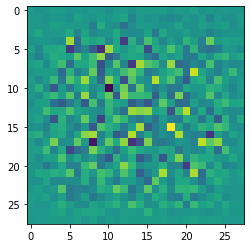

In [9]:
guided_model = GuidedGrad(model)
grad = guided_model.get_attribution(x, targets)
plt.imshow(grad.squeeze())
plt.show()

## VanillaGrad

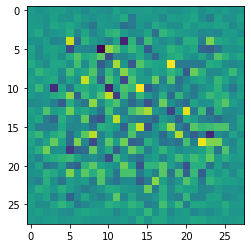

In [10]:
vanillagrad = VanillaGrad(model)
grad = vanillagrad.get_attribution(x, targets)
plt.imshow(grad.squeeze())
plt.show()

## InputGrad

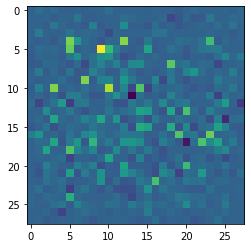

In [11]:
gradinput = InputGrad(model)
grad = gradinput.get_attribution(x, targets)
plt.imshow(grad.squeeze())
plt.show()

## DeconvNet

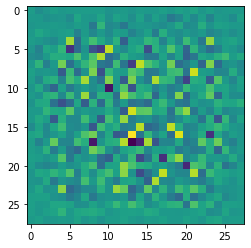

In [12]:
deconvnet = DeconvNet(model)
deconv = deconvnet.get_attribution(x, targets)
plt.imshow(deconv.squeeze())
plt.show()

## LRP

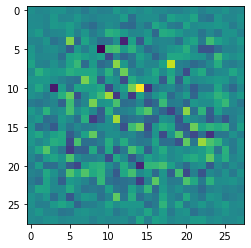

In [13]:
lrp_model = LRP(model)
lrp = lrp_model.get_attribution(x, targets)
plt.imshow(lrp.squeeze())
plt.show()